# Task 3: Gambling task

In [33]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from scipy.stats import linregress
from os.path import join
from matplotlib.colors import LinearSegmentedColormap
from seaborn.utils import relative_luminance
from seaborn.palettes import color_palette
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [27]:
DATA_FOLDER = 'data'
RESULTS_FOLDER = 'results/GamblingTask/'
GAMBLING_TASK = 'GamblingTask'
QUESTIONNAIRE = 'QuestionnaireData.csv'

num_participants = 164
remove_ids = [97, 105, 117, 36, 44, 90, 93, 95, 106, 134, 136, 155]

subject_ids = [i for i in range(1, num_participants + 1) if i not in remove_ids]

In [4]:
questionnaire_data = pd.read_csv(f'{DATA_FOLDER}/{QUESTIONNAIRE}')
questionnaire_data = questionnaire_data[~questionnaire_data['subj'].isin(remove_ids)]
questionnaire_data.reset_index(drop=True, inplace=True)
questionnaire_data.shape

(152, 17)

## Gambling task variables
- ppnr = participant number
- order = order in which the decks were presented, between 0 and 23 (24 possibilities)
- trialnr = trial number
- amount_won = amount of money won in current trial
- W_value_win = money that can be won in fixed deck in current trial
- X_value_win = money than can be won in SD = 10 deck in current trial
- Y_value_win = money that can be won in SD = 30 deck in current trial
- Z_value_win = money that can be won in SD = 70 deck in current trial
- r = response (1 = most left deck chosen, 2 = middle left chosen, 3 = middle right chosen, 4 = most right deck chosen)
- real_r = response (0 = fixed deck chosen, 1 = SD10 deck chosen, 2 = SD30 deck chosen, 3 = SD70 deck chosen)
- rt = reaction time in miliseconds
- money = total amount of money gathered in previous trials

In [11]:
file_path = f'{DATA_FOLDER}/{GAMBLING_TASK}/gambling_ppn01.rtd'
df = pd.read_csv(file_path, delimiter='\t')
df.shape

(200, 12)

In [12]:
# Read data for each participant and combine into a single dataframe
gambling_task_data = pd.DataFrame()

for subject_id in subject_ids:
    file_name = f"gambling_ppn{'0' + str(subject_id) if subject_id < 10 else str(subject_id)}.rtd"
    file_path = join(DATA_FOLDER, GAMBLING_TASK, file_name)
    temp_df = pd.read_csv(file_path, sep="\t", header=0)
    gambling_task_data = pd.concat([gambling_task_data, temp_df], ignore_index=True)
gambling_task_data.shape

(30400, 12)

In [13]:
# Check the columns in the dataframe
gambling_task_data.columns

Index(['ppnr', 'order', 'trialnr', 'amount_won', 'W_value_win', 'X_value_win',
       'Y_value_win', 'Z_value_win', 'r', 'real_r', 'rt', 'money'],
      dtype='object')

In [14]:
# Make a dataframe which counts the occurence of each choice for each participant
choices = pd.DataFrame(np.zeros((len(subject_ids), 5)), columns=["ppnr", "fixed", "SD10", "SD30", "SD70"])
choices["ppnr"] = subject_ids

# Loop over each subject
for k, subject_id in enumerate(subject_ids):
    # Count occurrences of each response type for the current subject
    choices.loc[k, "SD70"] = len(gambling_task_data[(gambling_task_data["real_r"] == 3) & (gambling_task_data["ppnr"] == subject_id)])
    choices.loc[k, "SD30"] = len(gambling_task_data[(gambling_task_data["real_r"] == 2) & (gambling_task_data["ppnr"] == subject_id)])
    choices.loc[k, "SD10"] = len(gambling_task_data[(gambling_task_data["real_r"] == 1) & (gambling_task_data["ppnr"] == subject_id)])
    choices.loc[k, "fixed"] = len(gambling_task_data[(gambling_task_data["real_r"] == 0) & (gambling_task_data["ppnr"] == subject_id)])

# Convert float columns to integers
choices = choices.astype({"fixed": int, "SD10": int, "SD30": int, "SD70": int})


In [17]:
# Filter out the participants who have chosen one or more decks less than 5 times
choices = choices[(choices["fixed"] >= 5) & (choices["SD10"] >= 5) & (choices["SD30"] >= 5) & (choices["SD70"] >= 5)]
excluded_participants = [i for i in subject_ids if i not in choices["ppnr"].values]
excluded_participants

[]

In [19]:
# Create a dataframe to store reaction time mean and standard deviation
reaction_time_mean = pd.DataFrame(columns=["ppnr", "mean", "sd"])
reaction_time_mean["ppnr"] = subject_ids

# Loop over each subject
for subject_id in subject_ids:
    # Calculate mean and standard deviation of reaction time for the current subject
    subject_data = gambling_task_data[gambling_task_data["ppnr"] == subject_id]
    mean_rt = subject_data["rt"].mean()
    sd_rt = subject_data["rt"].std()
    
    # Add mean and standard deviation to the dataframe
    reaction_time_mean.loc[reaction_time_mean["ppnr"] == subject_id, "mean"] = mean_rt
    reaction_time_mean.loc[reaction_time_mean["ppnr"] == subject_id, "sd"] = sd_rt

In [20]:
# Identify and mark outliers
for i, row in gambling_task_data.iterrows():
    participant_id = row["ppnr"]
    mean_rt = reaction_time_mean.loc[reaction_time_mean["ppnr"] == participant_id, "mean"].iloc[0]
    sd_rt = reaction_time_mean.loc[reaction_time_mean["ppnr"] == participant_id, "sd"].iloc[0]
    if row["rt"] - mean_rt > 3 * sd_rt:
        gambling_task_data.at[i, "rt"] = np.nan
        gambling_task_data.at[i, "real_r"] = np.nan

# Remove rows with NA values
gambling_task_data.dropna(inplace=True)

## Deck choice preference

In [21]:
# Get the preference dataframe
preference = pd.DataFrame(np.zeros((len(subject_ids), 5)), columns=["ppnr", "fixed", "SD10", "SD30", "SD70"])
preference["ppnr"] = subject_ids

# Loop over each subject
for k, subject_id in enumerate(subject_ids):
    # Subset data for the current subject
    subject_data = gambling_task_data[gambling_task_data["ppnr"] == subject_id]
    
    # Count occurrences of each deck choice
    num_fixed = len(subject_data[subject_data["real_r"] == 0])
    num_sd10 = len(subject_data[subject_data["real_r"] == 1])
    num_sd30 = len(subject_data[subject_data["real_r"] == 2])
    num_sd70 = len(subject_data[subject_data["real_r"] == 3])
    
    # Calculate proportions and store in the dataframe
    total_choices = num_fixed + num_sd10 + num_sd30 + num_sd70
    preference.loc[k, "fixed"] = num_fixed / total_choices
    preference.loc[k, "SD10"] = num_sd10 / total_choices
    preference.loc[k, "SD30"] = num_sd30 / total_choices
    preference.loc[k, "SD70"] = num_sd70 / total_choices

# Convert float columns to percentages
preference[["fixed", "SD10", "SD30", "SD70"]] *= 100

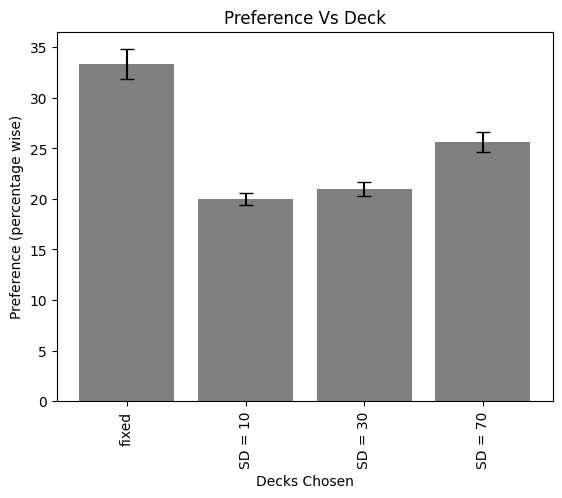

In [24]:
# Plot a barplot of preference against standard error of mean
preference_mean = preference.mean()  # Mean preference for each deck
preference_sem = preference.sem()    # SEM for each deck

# Define deck labels
deck_labels = ["fixed", "SD = 10", "SD = 30", "SD = 70"]

# Create bar plot
plt.bar(deck_labels, preference_mean[1:], color="gray", yerr=preference_sem[1:], capsize=5)

# Add labels and title
plt.xlabel("Decks Chosen")
plt.ylabel("Preference (percentage wise)")
plt.xticks(rotation=90)
plt.title("Preference Vs Deck")

# Save plot as image
plt.savefig(RESULTS_FOLDER+'/GamblingTask/Preference_Vs_Deck.png')

# Show plot
plt.show()

## Reaction time vs Deck chosen

In [25]:
# Mean and SD of reaction time
mean_rt = np.mean(gambling_task_data["rt"])
sd_rt = np.std(gambling_task_data["rt"])

print("Mean reaction time:", mean_rt)
print("Standard deviation of reaction time:", sd_rt)

Mean reaction time: 509.93188544542727
Standard deviation of reaction time: 498.53366075752245


In [26]:
# Create a dataframe to store mean reaction times for each participant for each deck
reaction_time = pd.DataFrame(np.zeros((len(subject_ids), 6)), columns=["ppnr", "fixed", "SD10", "SD30", "SD70", "mean"])
reaction_time["ppnr"] = subject_ids

# Loop over each subject
for k, subject_id in enumerate(subject_ids):
    # Subset data for the current subject
    subject_data = gambling_task_data[gambling_task_data["ppnr"] == subject_id]
    
    # Calculate mean reaction time for each deck choice and overall mean
    reaction_time.loc[k, "fixed"] = subject_data[subject_data["real_r"] == 0]["rt"].mean()
    reaction_time.loc[k, "SD10"] = subject_data[subject_data["real_r"] == 1]["rt"].mean()
    reaction_time.loc[k, "SD30"] = subject_data[subject_data["real_r"] == 2]["rt"].mean()
    reaction_time.loc[k, "SD70"] = subject_data[subject_data["real_r"] == 3]["rt"].mean()
    reaction_time.loc[k, "mean"] = subject_data["rt"].mean()

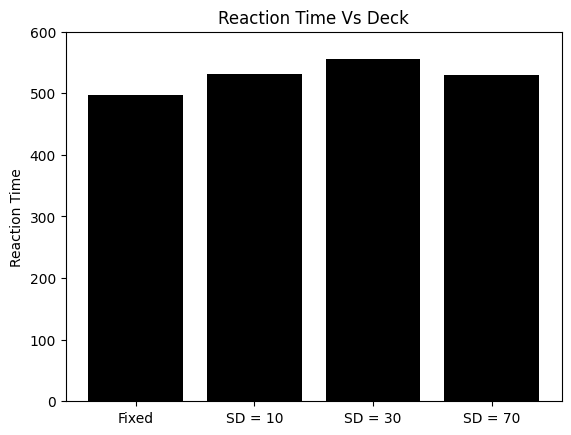

In [28]:
# bar plot of mean reaction time for different deck types
conditions = ["Fixed", "SD = 10", "SD = 30", "SD = 70"]
means = [reaction_time["fixed"].mean(), reaction_time["SD10"].mean(), reaction_time["SD30"].mean(), reaction_time["SD70"].mean()]

# Create bar plot
plt.bar(conditions, means, color="black")

# Set labels and title
plt.xlabel("")
plt.ylabel("Reaction Time")
plt.ylim(0, 600)
plt.title("Reaction Time Vs Deck")

# Save plot as image
plt.savefig(RESULTS_FOLDER+'Reaction_Time_Vs_Deck.png')

# Show plot
plt.show()

In [29]:
# Create a function to better format the numeric values
def abbreviateSTR(value, prefix):
    ret = []
    for item in value:
        if np.isnan(item) or pd.isna(item):
            ret.append('')
            continue
        item = round(item, 2)
        if item == 0:
            item = '<.01'
        item = str(item)
        item = item.lstrip('0')  # remove leading 0: 0.05 -> .05
        item = item.replace('-0', '-')  # remove leading -0: -0.05 -> -.05
        ret.append(prefix + item)
    return ret

## Linear regression

In [31]:
# Linear regression analysis and checking for multicollinearity using VIF
corr_data = pd.concat([preference["fixed"], questionnaire_data.iloc[:, [5, 6, 7, 8, 9, 10, 12, 13, 14, 15]]], axis=1)
corr_data.columns = ["fixed_deck", 'AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'AQ_binary', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']

# Handle missing values by imputing with mean
corr_data.fillna(corr_data.mean(), inplace=True)

# Fit linear regression model
X = corr_data[['AQ_social', 'AQ_switch', 'AQ_detail', 'AQ_comm', 'AQ_imag', 'AQ_binary', 'SRS_consc', 'SRS_comm', 'SRS_motiv', 'SRS_rigid']]
X = sm.add_constant(X)  # Add constant term
y = corr_data['fixed_deck']
fitScores = sm.OLS(y, X).fit()

# Print summary statistics
print(fitScores.summary())

# Calculate VIF
vif_data = X.drop(columns='const')
vif = pd.DataFrame()
vif["Variable"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
print(vif)

                            OLS Regression Results                            
Dep. Variable:             fixed_deck   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.8218
Date:                Sun, 14 Apr 2024   Prob (F-statistic):              0.608
Time:                        19:20:10   Log-Likelihood:                -649.20
No. Observations:                 152   AIC:                             1320.
Df Residuals:                     141   BIC:                             1354.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4671     21.240      1.952      0.0

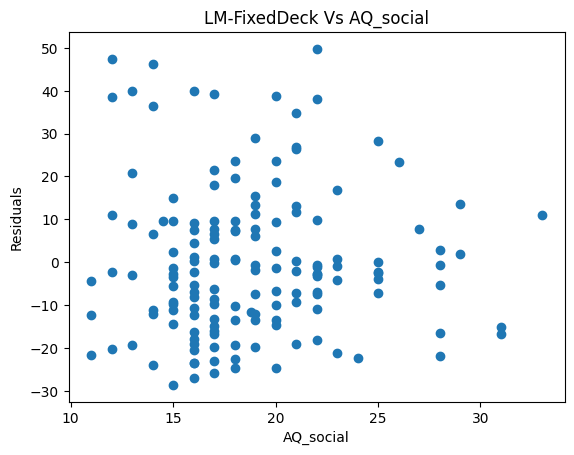

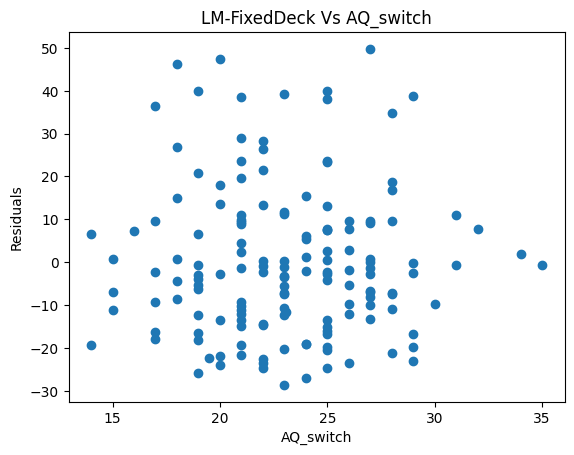

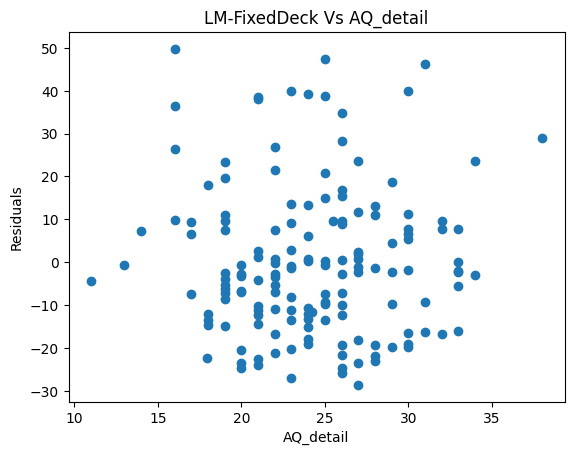

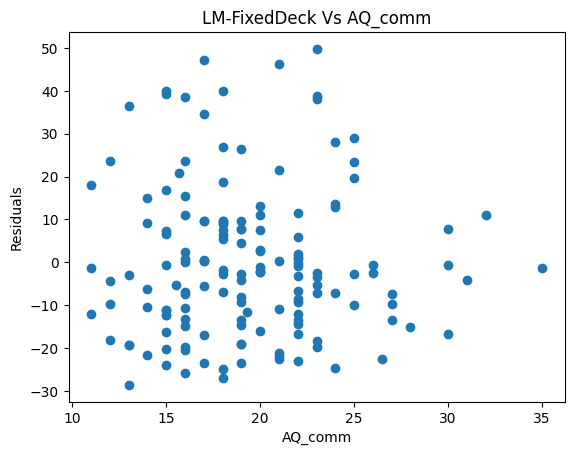

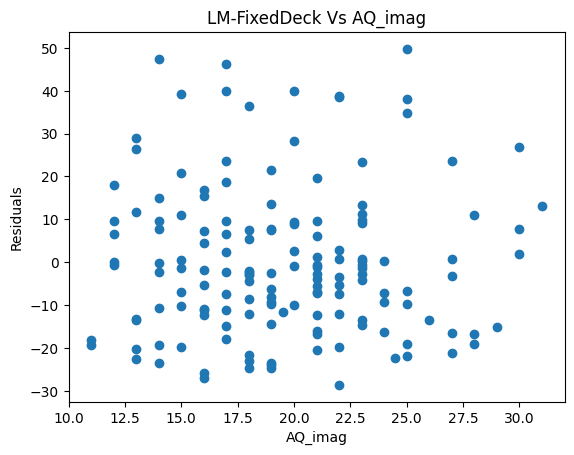

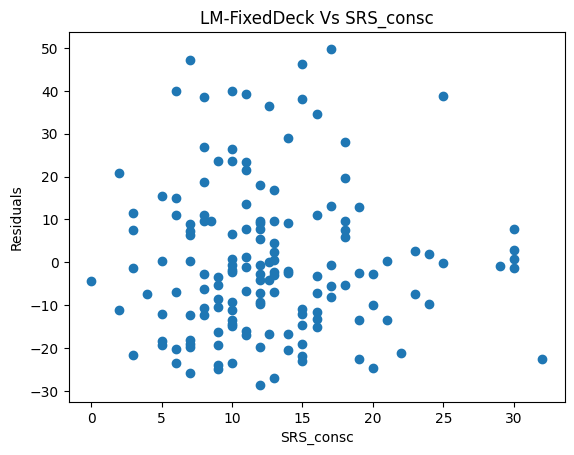

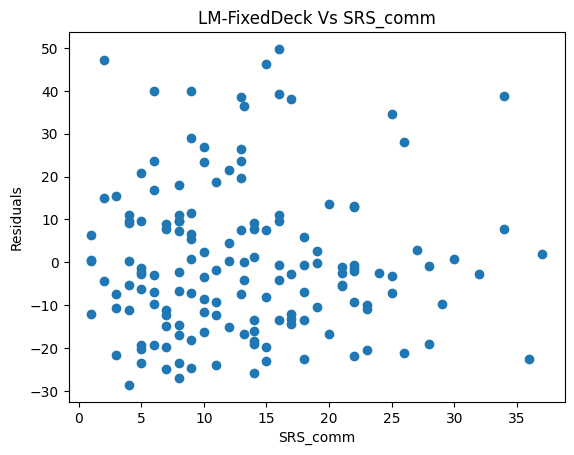

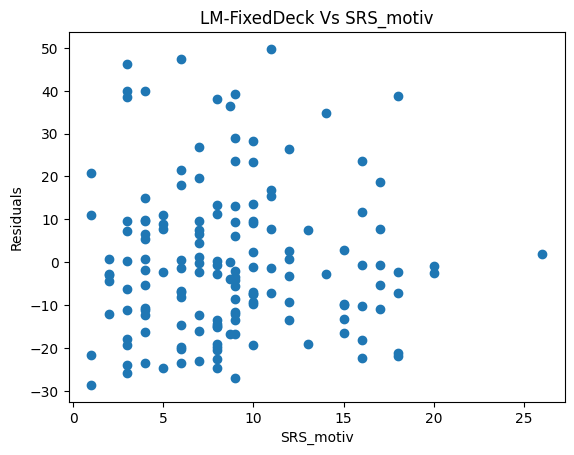

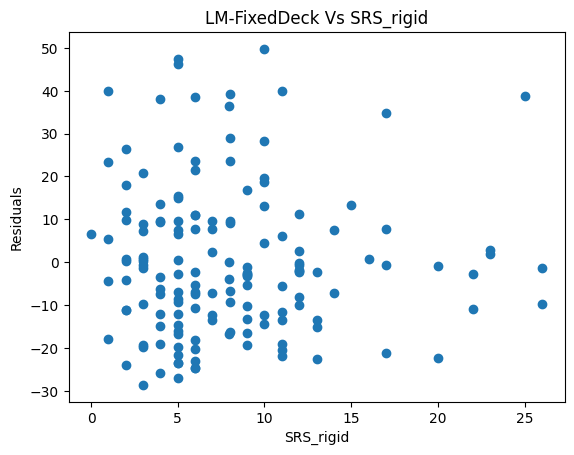

In [35]:
# Create plots of the regression
def generate_effect_plot(pred_var, filename):
    plt.scatter(corr_data[pred_var], fitScores.resid)
    plt.title(f'LM-FixedDeck Vs {pred_var}')
    plt.xlabel(pred_var)
    plt.ylabel('Residuals')
    plt.savefig(RESULTS_FOLDER+filename)
    plt.show()
    plt.close()

# Generate effect plots and save images
generate_effect_plot('AQ_social', 'LM-FixedDeck_Vs_AQSocial.png')
generate_effect_plot('AQ_switch', 'LM-FixedDeck_Vs_AQSwitch.png')
generate_effect_plot('AQ_detail', 'LM-FixedDeck_Vs_AQDetail.png')
generate_effect_plot('AQ_comm', 'LM-FixedDeck_Vs_AQComm.png')
generate_effect_plot('AQ_imag', 'LM-FixedDeck_Vs_AQImag.png')
generate_effect_plot('SRS_consc', 'LM-FixedDeck_Vs_SRSConsc.png')
generate_effect_plot('SRS_comm', 'LM-FixedDeck_Vs_SRSComm.png')
generate_effect_plot('SRS_motiv', 'LM-FixedDeck_Vs_SRSMotiv.png')
generate_effect_plot('SRS_rigid', 'LM-FixedDeck_Vs_SRSRigid.png')

In [39]:
# Relation between factorscores, AQ_total, SRS_total and preference for fixed deck
corr_data = pd.concat([preference["fixed"], questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)

# Rename the columns for better understanding
corr_data.columns = ["preference_fixed", 'AQ_total', 'SRS_total', 'factorscores']
# Handle missing values by imputing with mean
corr_data.fillna(corr_data.mean(), inplace=True)
X = corr_data[['AQ_total', 'SRS_total', 'factorscores']]
y = corr_data['preference_fixed']

# Add a constant term to the predictor variables matrix for the intercept
X = sm.add_constant(X)

# Fit the linear regression model
fitScores_orig = sm.OLS(y, X).fit()

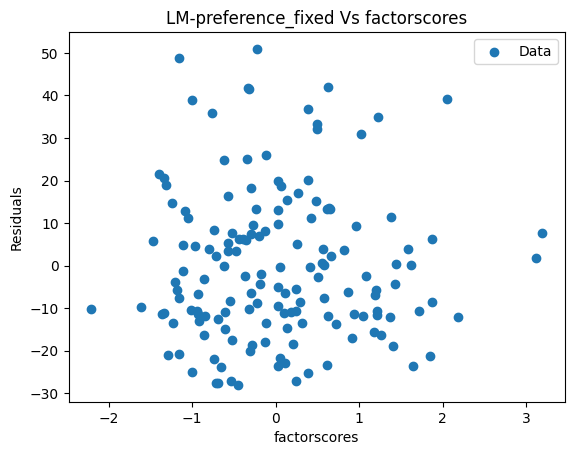

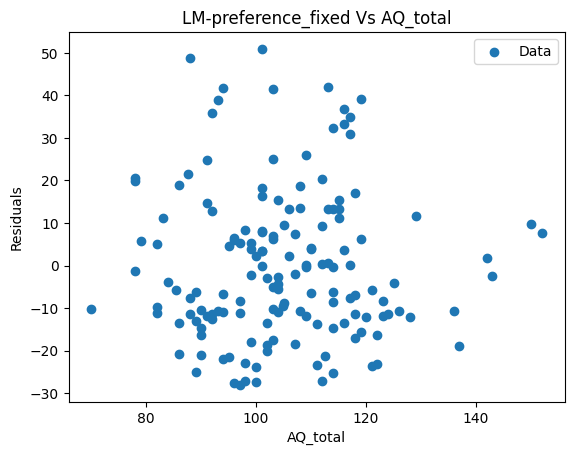

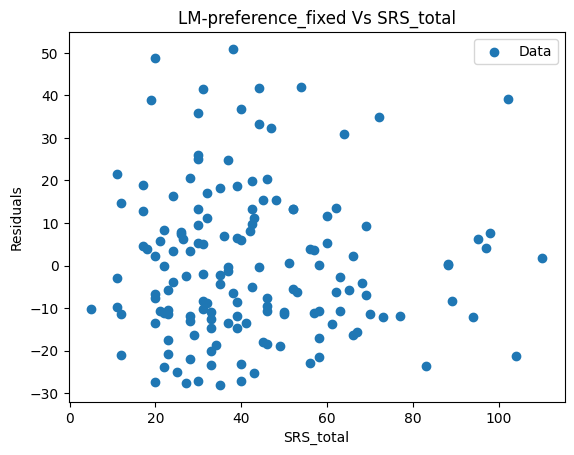

In [42]:
# Plot the residuals
def generate_effect_plot(pred_var, fit_model, filename):
    # Scatter plot of predictor variable vs residuals
    plt.scatter(corr_data[pred_var], fit_model.resid, label='Data')

    plt.title(f'LM-preference_fixed Vs {pred_var}')
    plt.xlabel(pred_var)
    plt.ylabel('Residuals')
    plt.legend()
    plt.savefig(RESULTS_FOLDER+filename)
    plt.show()
    plt.close()

# Generate effect plots without trend lines and save images
generate_effect_plot('factorscores', fitScores_orig, 'LM-preference_fixed_Vs_factorscores.png')
generate_effect_plot('AQ_total', fitScores_orig, 'LM-preference_fixed_Vs_AQ_total.png')
generate_effect_plot('SRS_total', fitScores_orig, 'LM-preference_fixed_Vs_SRS_total.png')

In [44]:
# Linear regression on preference for fixed deck against AQ_total and SRS_total
X = sm.add_constant(corr_data[['AQ_total', 'SRS_total']])
y = corr_data['preference_fixed']
fitScores_orig = sm.OLS(y, X).fit()

# Print summary of regression results
print(fitScores_orig.summary())

# Calculate Variance Inflation Factor (VIF) to check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif_data = X.drop(columns='const')
vif_series = pd.Series([variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])], index=vif_data.columns)
print('VIF:')
print(vif_series) 

                            OLS Regression Results                            
Dep. Variable:       preference_fixed   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8091
Date:                Sun, 14 Apr 2024   Prob (F-statistic):              0.447
Time:                        19:46:00   Log-Likelihood:                -652.69
No. Observations:                 152   AIC:                             1311.
Df Residuals:                     149   BIC:                             1320.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.4358     11.868      3.491      0.0

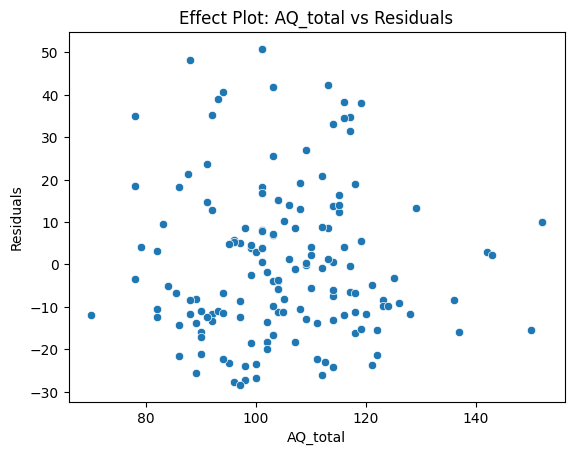

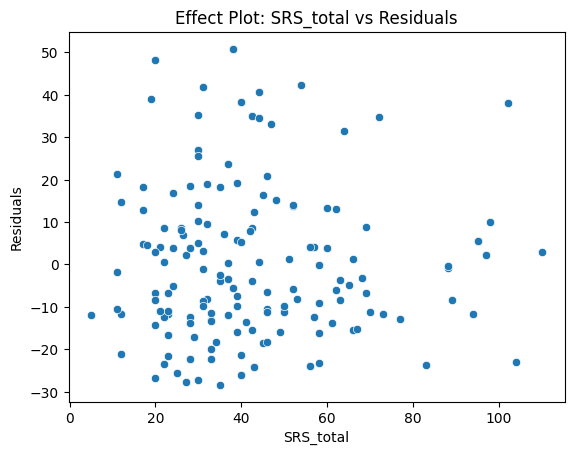

In [47]:
# Effect plot for AQ_total
sns.scatterplot(x=corr_data['AQ_total'], y=fitScores_orig.resid)
plt.xlabel('AQ_total')
plt.ylabel('Residuals')
plt.title('Effect Plot: AQ_total vs Residuals')
plt.savefig(RESULTS_FOLDER+'LM-FixedDeck_Vs_AQ_Total.png')
plt.show()

# Effect plot for SRS_total
sns.scatterplot(x=corr_data['SRS_total'], y=fitScores_orig.resid)
plt.xlabel('SRS_total')
plt.ylabel('Residuals')
plt.title('Effect Plot: SRS_total vs Residuals')
plt.savefig(RESULTS_FOLDER+'LM-FixedDeck_Vs_SRS_Total.png')
plt.show()

In [48]:
# Calculate AIC for fitScores_orig
aic_orig = fitScores_orig.aic

# Calculate AIC for fitScores (assuming you have fitScores available)
aic = fitScores.aic

print("AIC for fitScores_orig:", aic_orig) # Lesser aic suggests a potentially better model
print("AIC for fitScores:", aic)

AIC for fitScores_orig: 1311.373197308398
AIC for fitScores: 1320.404614196906


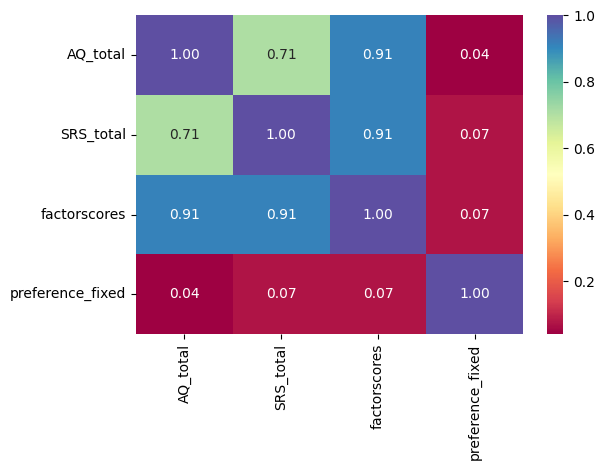

In [53]:
# Plot the spearmans correlation between preference for corr_data
cormatrix, p_values = spearmanr(corr_data)

# Convert correlation matrix to DataFrame
cordata = pd.DataFrame(cormatrix, index=corr_data.columns, columns=corr_data.columns)

# Melt the DataFrame to long format
cordata = cordata.unstack().reset_index(name='value').rename(columns={'level_0': 'X1', 'level_1': 'X2'})

# Abbreviate correlation values
cordata['labelr'] = cordata['value'].apply(lambda x: f'{x:.2f}')

# Create a pivot table
cordata_pivot = cordata.pivot_table(index='X1', columns='X2', values='value')

# Create a heatmap
sns.heatmap(cordata_pivot, annot=True, fmt=".2f", cmap='Spectral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_Deck_with_totals_Spearman.png")
plt.show()

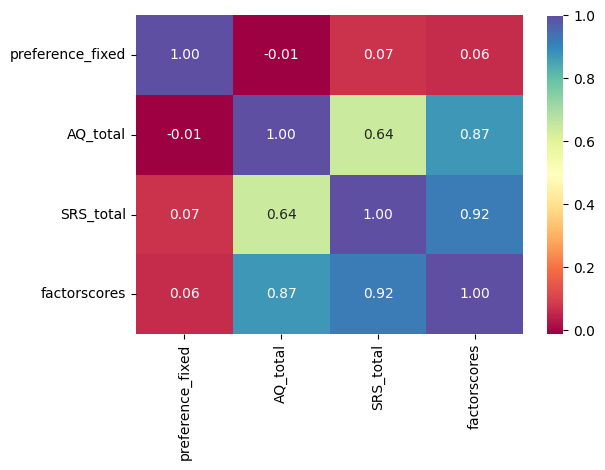

In [54]:
# Pearson correlation between preference for fixed deck and AQ_total
cormatrix = corr_data.corr(method='pearson')

# Melt the DataFrame to long format
cordata = cormatrix.unstack().reset_index(name='value').rename(columns={'level_0': 'X1', 'level_1': 'X2'})

# Abbreviate correlation values
cordata['labelr'] = cordata['value'].apply(lambda x: f'{x:.2f}')

# Create a heatmap
sns.heatmap(cormatrix, annot=True, fmt=".2f", cmap='Spectral')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_Deck_with_totals_Pearson.png")
plt.show()

C:\Users\aabhi\AppData\Local\Temp\ipykernel_17848\2629049073.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  label_df_r = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'r=')[0])
C:\Users\aabhi\AppData\Local\Temp\ipykernel_17848\2629049073.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  label_df_p = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'P=')[0])


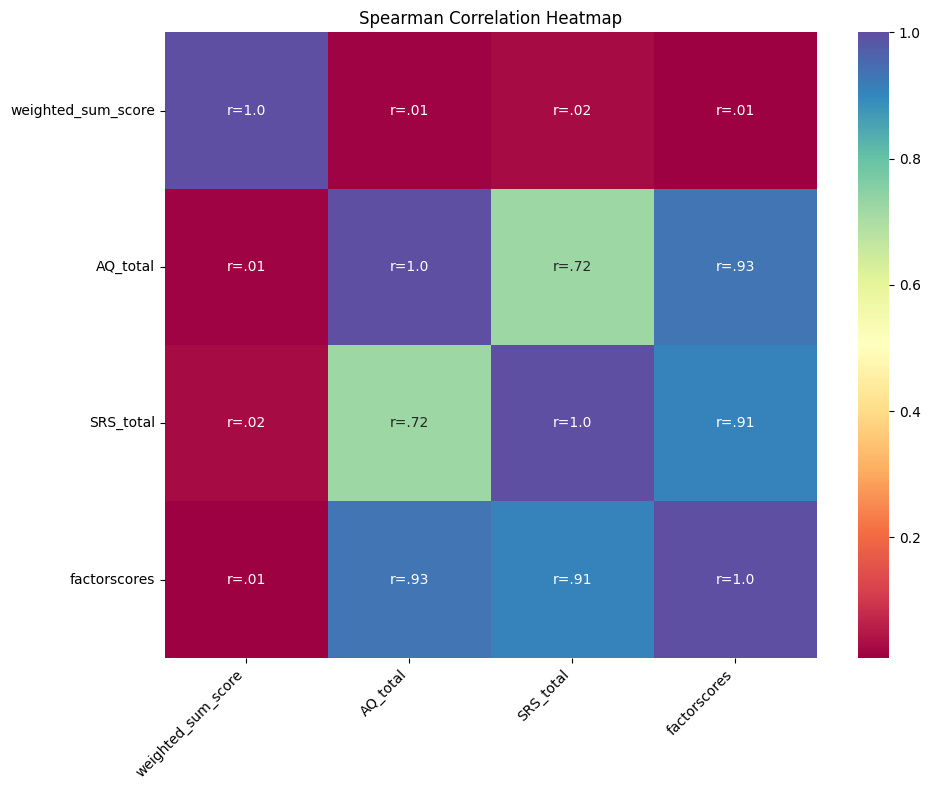

In [57]:
# Correlation between weighted sum 
weighted_sum_score = (preference['fixed'] * 1) + (preference['SD10'] * 2) + (preference['SD30'] * 3) + (preference['SD70'] * 4)

# Combine data into a DataFrame
corr_data = pd.concat([weighted_sum_score, questionnaire_data[['AQ_total', 'SRS_total', 'PCA_factor']]], axis=1)
corr_data.columns = ['weighted_sum_score', 'AQ_total', 'SRS_total', 'factorscores']

# Calculate Spearman correlation
correlation_matrix = corr_data.corr(method='spearman')

# Apply abbreviateSTR function to format correlation coefficient and p-value strings
label_df_r = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'r=')[0])
label_df_p = correlation_matrix.applymap(lambda x: abbreviateSTR([x], 'P=')[0])

# Plot heatmap with formatted labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=label_df_r.values, cmap='Spectral', fmt="", annot_kws={"size": 10})
plt.title('Spearman Correlation Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(RESULTS_FOLDER+"Correlations_of_weightedsums_with_totals_S.png")
plt.show()

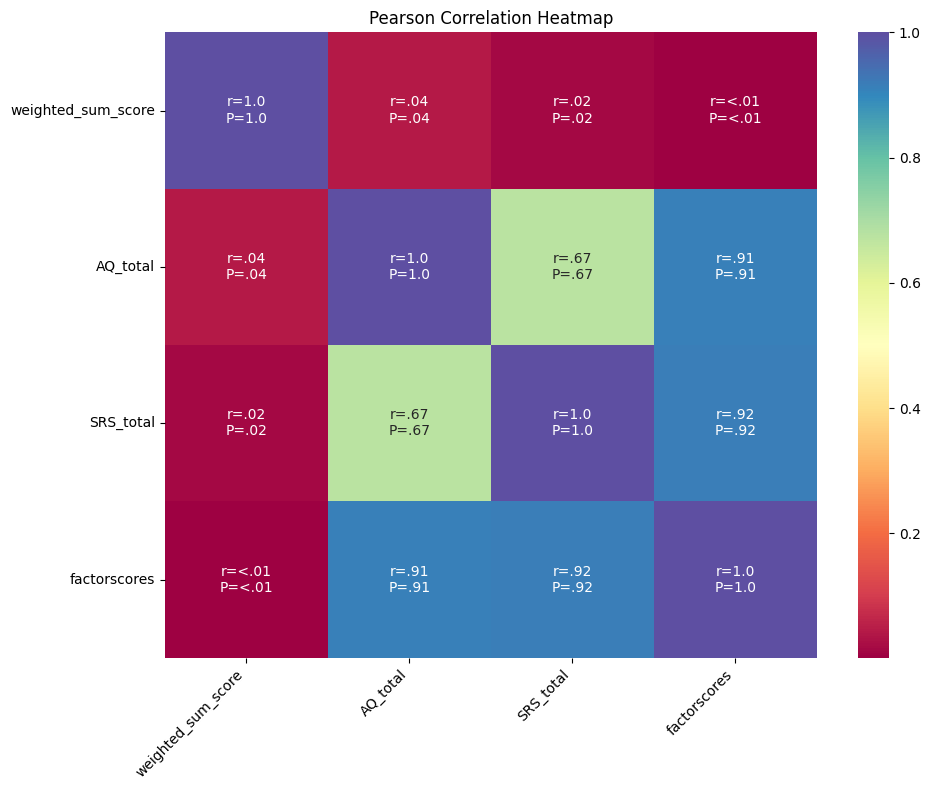

In [58]:
correlation_matrix = corr_data.corr(method='pearson')

# Melt the correlation matrix for visualization
cordata = correlation_matrix.reset_index().melt(id_vars='index')

# Apply abbreviateSTR function to format correlation coefficient and p-value strings
cordata['labelr'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'r=')[0])
cordata['labelP'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'P=')[0])
cordata['label'] = cordata['labelr'] + '\n' + cordata['labelP']

# Plot heatmap with formatted labels
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=cordata['label'].values.reshape(correlation_matrix.shape), cmap='Spectral', fmt="", annot_kws={"size": 10})
plt.title('Pearson Correlation Heatmap')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(RESULTS_FOLDER+"Correlations_of_weightedsums_with_totals_P.png")
plt.show()

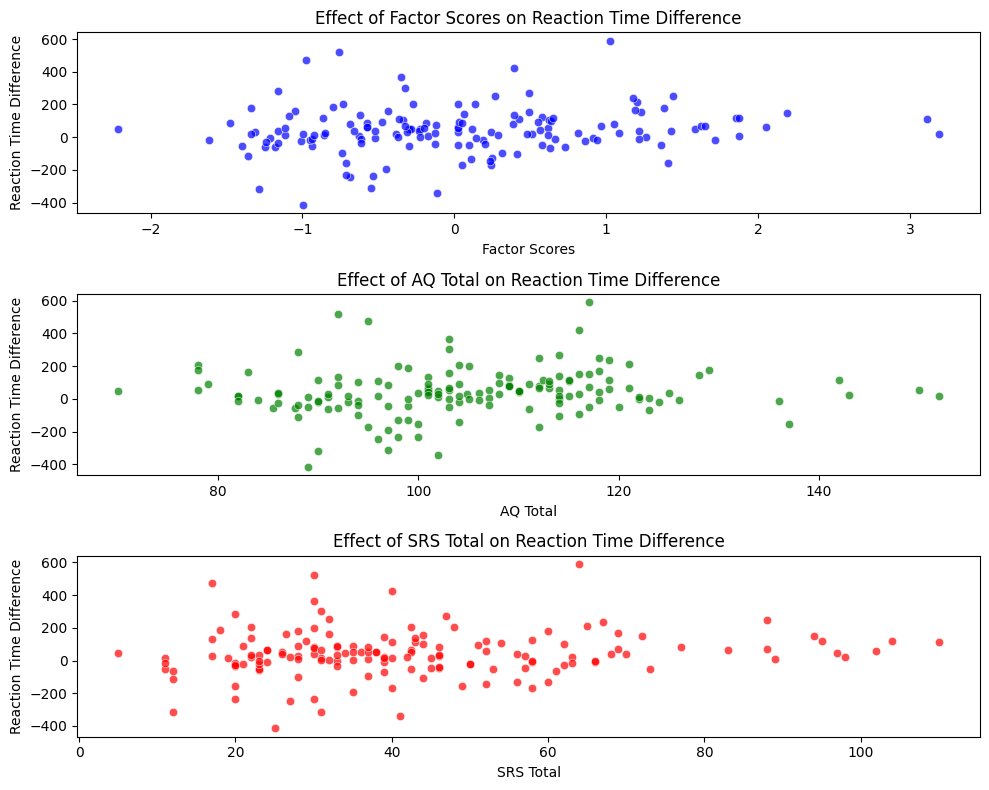

In [61]:
# Linear regression on reaction time as the response variable

reaction_time_diff = np.mean(reaction_time.iloc[:, 2:5], axis=1) - reaction_time['fixed']

# Combine with questionnaire data
corr_data = pd.concat([reaction_time_diff, questionnaire_data.iloc[:, [4, 11, 16]]], axis=1)
corr_data.columns = ['RT_diff', 'AQ_total', 'SRS_total', 'factorscores']
# Handle missing values by imputing with mean
corr_data.fillna(corr_data.mean(), inplace=True)

# Fit linear regression model
X = sm.add_constant(corr_data[['AQ_total', 'SRS_total', 'factorscores']])
y = corr_data['RT_diff']
fitScores_orig = sm.OLS(y, X).fit()

# Generate effect plots
plt.figure(figsize=(10, 8))
plt.subplot(3, 1, 1)
sns.scatterplot(data=corr_data, x='factorscores', y='RT_diff', color='blue', alpha=0.7)
plt.title('Effect of Factor Scores on Reaction Time Difference')
plt.xlabel('Factor Scores')
plt.ylabel('Reaction Time Difference')

plt.subplot(3, 1, 2)
sns.scatterplot(data=corr_data, x='AQ_total', y='RT_diff', color='green', alpha=0.7)
plt.title('Effect of AQ Total on Reaction Time Difference')
plt.xlabel('AQ Total')
plt.ylabel('Reaction Time Difference')

plt.subplot(3, 1, 3)
sns.scatterplot(data=corr_data, x='SRS_total', y='RT_diff', color='red', alpha=0.7)
plt.title('Effect of SRS Total on Reaction Time Difference')
plt.xlabel('SRS Total')
plt.ylabel('Reaction Time Difference')

plt.tight_layout()
plt.savefig(RESULTS_FOLDER+'LM_Totals_vs_RT.png')
plt.show()

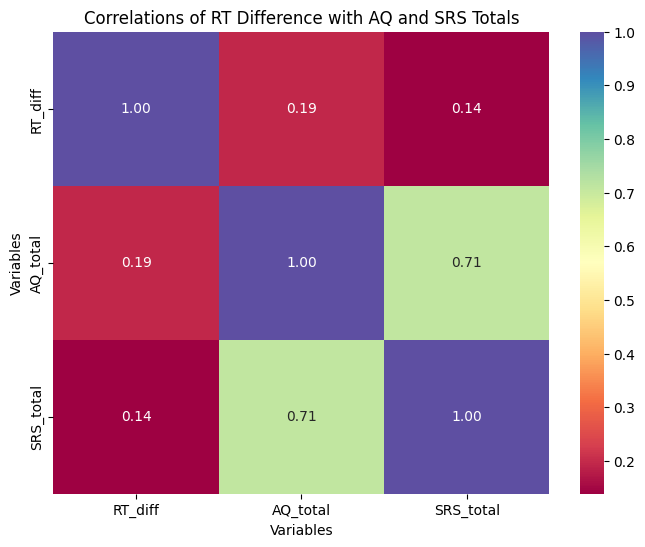

In [66]:
X = corr_data[['AQ_total', 'SRS_total']]
y = corr_data['RT_diff']
fitScores_orig = sm.OLS(y, sm.add_constant(X)).fit()

# Calculate Spearman correlation coefficients
spearman_corr, spearman_pval = spearmanr(corr_data[['RT_diff', 'AQ_total', 'SRS_total']], nan_policy='omit')

# Create DataFrame for correlation coefficients
cordata = pd.DataFrame(spearman_corr, columns=['RT_diff', 'AQ_total', 'SRS_total'])
cordata.index = ['RT_diff', 'AQ_total', 'SRS_total']
cordata.columns = ['RT_diff', 'AQ_total', 'SRS_total']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cordata, annot=True, fmt=".2f", cmap='Spectral')
plt.title('Correlations of RT Difference with AQ and SRS Totals')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.savefig(RESULTS_FOLDER+'Correlations_of_RTDiff_with_totals_Spearman.png')
plt.show()

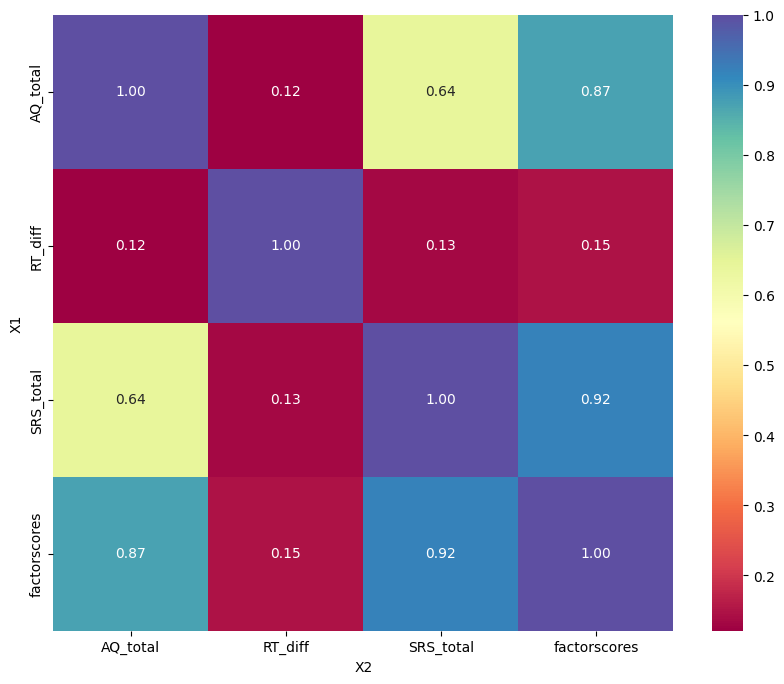

In [69]:
cormatrix = corr_data.corr(method='pearson')

# Reshape the correlation matrix into long format
cordata = cormatrix.unstack().reset_index()
cordata.columns = ['X1', 'X2', 'value']

# Apply abbreviateSTR function to format correlation coefficient strings
cordata['labelr'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'r=')[0])
cordata['labelP'] = cordata['value'].apply(lambda x: abbreviateSTR([x], 'P=')[0])
cordata['label'] = cordata['labelr'] + '\n' + cordata['labelP']

# Set up plot aesthetics
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(cordata.pivot(index='X1', columns='X2', values='value'), annot=True, fmt=".2f", cmap='Spectral')

# Save the plot
plt.savefig(RESULTS_FOLDER+"Correlations_of_RTDiff_with_totals_Pearson.png")

# Show the plot
plt.show()